# Deploy del Modelo de NN para el Opera y Cumple (OyC)

In [1]:
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from tensorflow.metrics import precision
from keras import backend as K
import tensorflow as tf
from sklearn.metrics import roc_auc_score
def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)


def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
# Compilo un modelo con la misma arquitectura que tenia antes. 
model = Sequential()
model.add(Dense(500, input_dim=22, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(125, activation='relu'))
model.add(Dense(75, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=[precision_m, auroc, 'accuracy'])

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


In [2]:
# Cargo los pesos del mejor modelo que obtuve
model.load_weights('model_small2-90-0.77.hdf5')

In [3]:
# Importo todas las variables que utilice para entrenar/testear.
import pickle
with open('variables.pickle', 'rb') as handle:
    scaler,X_train,X_test,y_train,y_test,X_train_std,X_test_std = pickle.load(handle)

In [4]:
for m,s in enumerate(zip(scaler.mean_ ,scaler.scale_)):
    print (m+1,s)

1 (535.1683786294193, 306.06027527537265)
2 (41.65613061440225, 15.712608188947394)
3 (1.4611417489613574, 1.3010300816305989)
4 (221.6913881083686, 363.5155868190148)
5 (0.34456116623333216, 0.643491126587759)
6 (375.25674388959493, 400.8660696803913)
7 (18.02313967361945, 33.45913156034686)
8 (73.23666281912269, 41.44399131123062)
9 (0.2114788948610026, 0.40835716216245266)
10 (0.3531384688329505, 0.4779452799884833)
11 (0.5346997944090134, 0.49879447096772456)
12 (0.3936037496065012, 0.4885487057624898)
13 (0.08901817673052036, 0.2847699790042732)
14 (3.946033337608382, 1.591488838772328)
15 (9.128997130211513, 11.246478731829377)
16 (0.18421185587644331, 0.3876568689330808)
17 (0.2903885242142655, 0.4539416583867651)
18 (0.2345874772159327, 0.42374071405683567)
19 (0.46769034655100716, 0.4989549942570032)
20 (4.152502652473505, 4.0420590141126675)
21 (461.39345995250807, 843.1040406881012)
22 (24.761181789778586, 17.840697153021345)


In [14]:
scaler.mean_


array([5.35168379e+02, 4.16561306e+01, 1.46114175e+00, 2.21691388e+02,
       3.44561166e-01, 3.75256744e+02, 1.80231397e+01, 7.32366628e+01,
       2.11478895e-01, 3.53138469e-01, 5.34699794e-01, 3.93603750e-01,
       8.90181767e-02, 3.94603334e+00, 9.12899713e+00, 1.84211856e-01,
       2.90388524e-01, 2.34587477e-01, 4.67690347e-01, 4.15250265e+00,
       4.61393460e+02, 2.47611818e+01])

In [15]:
scaler.scale_

array([3.06060275e+02, 1.57126082e+01, 1.30103008e+00, 3.63515587e+02,
       6.43491127e-01, 4.00866070e+02, 3.34591316e+01, 4.14439913e+01,
       4.08357162e-01, 4.77945280e-01, 4.98794471e-01, 4.88548706e-01,
       2.84769979e-01, 1.59148884e+00, 1.12464787e+01, 3.87656869e-01,
       4.53941658e-01, 4.23740714e-01, 4.98954994e-01, 4.04205901e+00,
       8.43104041e+02, 1.78406972e+01])

In [16]:
X_train.columns

Index(['score', 'age', 'nconsultas', 'mesesBancarizacion', 'operaYcumple',
       'score_enconsulta_min', 'ANTIGUEDAD_LAB', 'tiempo_interconsulta_min',
       'JUBILADO', 'RELAC_DEP', 'usa_score', 'tieneObraSocial', 'autonomo',
       'scorecard', 'compromiso', 'class_F', 'class_R', 'class_T', 'sex_1.0',
       'cantBancos', 'modeloAuto', 'ingresoFilled'],
      dtype='object')

In [5]:
# COmputo la performance del modelo sobre el set de entremiento (loss,Precision,AUC,accuracy)
model.evaluate(X_test_std,y_test)

64327/64327 [==============================] - 6s 100us/step


[0.7990471227221213,
 0.7746960794004476,
 0.8289578081920802,
 0.7600230074463289]

In [6]:
# Exporto el modelo como tablas de pesos y sesgos. 
def model2csv(model):
  weights = []
  biases = []
  for layer in model.layers: weights.append(layer.get_weights()[0])
  for layer in model.layers: biases.append(layer.get_weights()[1])  
  csvW=""
  csvB=""

  for i in range (len(biases)):
      for j in range(len(biases[i])):
        csvB += str(i+1) + ',' + str(j+1) + ',' + str(biases[i][j]) + '\n'

  for i in range (len(weights)):
    for j in range(len(weights[i])):
      for k in range(len(weights[i][j])):
        csvW += str(i+1) + ',' + str(k+1) + ',' + str(j+1) + ',' + str(weights[i][j][k]) + '\n'
  return csvW,csvB
csvW,csvB = model2csv(model)

# Exporto la Tabla de pesos
f = open( 'weights_small.csv', 'w' )
f.write(csvW)
f.close()

# Exporto la Tabla de sesgos
f = open( 'biases_small.csv', 'w' )
f.write(csvB)
f.close()


In [7]:
#Imprimo la primer prediccion y el vector que la genero.
selected_point=123
# Vector de caracteristicas 
print(X_test.iloc[selected_point,:])
print(X_test_std[selected_point])
print('Prediccion:',model.predict(X_test_std[selected_point].reshape(1,-1)))



score                       932.0
age                          53.0
nconsultas                    3.0
mesesBancarizacion           32.0
operaYcumple                  1.0
score_enconsulta_min        920.0
ANTIGUEDAD_LAB              128.0
tiempo_interconsulta_min      2.0
JUBILADO                      0.0
RELAC_DEP                     1.0
usa_score                     1.0
tieneObraSocial               1.0
autonomo                      0.0
scorecard                     4.0
compromiso                    5.4
class_F                       0.0
class_R                       0.0
class_T                       0.0
sex_1.0                       0.0
cantBancos                    3.0
modeloAuto                    0.0
ingresoFilled                42.0
Name: 176378, dtype: float64
[ 1.29657997  0.72195967  1.1827999  -0.52182463  1.01856701  1.35891585
  3.28690122 -1.71886589 -0.51787728  1.35342174  0.93284957  1.24121964
 -0.31259677  0.03390954 -0.33157019 -0.47519307 -0.63970451 -0.5536109
 -0.9

In [8]:
from sklearn.metrics import precision_score

# Genero una lista de tuplas (threshold, score, proporcionOyC)
precision_lst=[]
for t in [0.5, 0.60,0.70,0.75,0.80,0.85, 0.90, 0.95]:
    y_test_pred = (model.predict(X_test_std) >=t).astype('int64')
    score= precision_score(y_test, y_test_pred)
    precision_lst.append((t,score,y_test_pred.mean()))


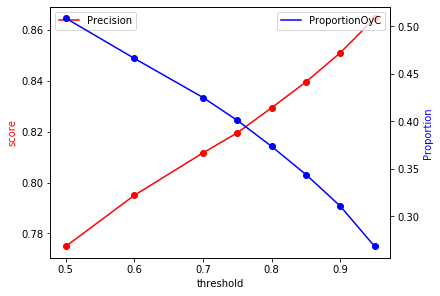

In [17]:
# Grafico los resultados. 
import matplotlib.pyplot as plt

x = [x[0] for x in precision_lst]
y = [x[1] for x in precision_lst]
z = [x[2] for x in precision_lst]
fig, ax = plt.subplots(constrained_layout=True)
ax2 = ax.twinx()
ax.plot(x,y,'ro')
ax.plot(x,y,'r-',label='Precision')
ax2.plot(x,z,'bo')
ax2.plot(x,z,'b-',label='ProportionOyC')
ax.set_xlabel('threshold')
ax.set_ylabel('score', color='r')
ax2.set_ylabel('Proportion', color='b');
ax.legend()
ax2.legend()